In [1]:
import itertools
import matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tqdm import tqdm
from scipy.spatial import distance

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
np.random.seed(0)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y_train = np.argmax(y_train, axis=1)

order = np.random.permutation(len(x_train))

x_train = x_train[order]
y_train = y_train[order]


y_train = tf.keras.utils.to_categorical(y_train, 10)

x_train_reshape = [x_train[i].reshape((784)) for i in range(len(x_train))]
print(np.array(x_train_reshape).shape)

x_test_reshape = [x_test[i].reshape((784)) for i in range(len(x_test))]
print(np.array(x_test_reshape).shape)

(60000, 784)
(10000, 784)


In [5]:
n_hidden_neurons = 64
lr = 0.001
epochs = 200
batch_size = 8
limit = 4096 # number of training examples to use.
alpha = 0.0 # ignore polysemantic term in loss function.

In [6]:
i = tf.keras.layers.Input(shape=(28*28,))
i2 = tf.keras.layers.Input(shape=(10,))
e = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_1')(i)
o = tf.keras.layers.Dense(10, activation='softmax', name='softmax')(e)
model = tf.keras.Model(inputs=[i, i2], outputs=o)

2022-05-20 16:52:15.903641: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-20 16:52:15.922990: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc268b1c070 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-20 16:52:15.923012: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


### define polysemantic loss

In [7]:
def calculate_term(e, c0, c1):
  a = K.expand_dims(e[c0] / (K.max(K.abs(e[c0])) + 1e-9))
  b = K.expand_dims(e[c1] / (K.max(K.abs(e[c1])) + 1e-9))
  return K.dot(K.transpose(a), b)

In [8]:
#https://stackoverflow.com/questions/62454500/how-to-use-tensorflow-custom-loss-for-a-keras-model
def my_loss(y_true, y_pred, e, c0, c1, alpha):
    p_loss = 0
    for i in range(len(c0)):
       p_loss += (1. - (tf.cast(tf.equal(K.argmax(y_true[c0[i]]), K.argmax(y_true[c1[i]])), dtype='float32'))) \
              * calculate_term(e, c0[i], c1[i])
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=y_true, 
                                                                      y_pred=y_pred)
    loss += alpha * (p_loss / len(c0))
    return loss

### precalculate all indices for batch_size choose 2 pairs

In [9]:
c0, c1 = [], []
for c in list(itertools.combinations(range(batch_size), 2)):
    c0.append(c[0])
    c1.append(c[1])

In [10]:
print(len(c0))

28


In [11]:
model.add_loss(my_loss(i2, o, e, np.array(c0, dtype='int32'), np.array(c1, dtype='int32'), alpha))

In [13]:
def my_acc(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, tf.constant([0.5])), dtype='float32')
    return tf.cast(tf.math.equal(y_true, y_pred), dtype='float32')

def cce(y_true, y_pred):
    return tf.keras.losses.CategoricalCrossentropy(
        from_logits=False,
        reduction=tf.keras.losses.Reduction.NONE
    )(y_true=y_true, y_pred=y_pred)

def ps_term(y_true, e, c0, c1):
    p_loss = []
    for i in range(len(c0)):
         p_loss.append((1. - (tf.cast(tf.equal(K.argmax(y_true[c0[i]]), K.argmax(y_true[c1[i]])), dtype='float32'))) \
              * calculate_term(e, c0[i], c1[i]))
    return tf.convert_to_tensor(p_loss)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=None)

model.add_metric(my_acc(i2, o), name='acc', aggregation='mean')
model.add_metric(cce(i2, o), name='cce', aggregation='mean')
model.add_metric(ps_term(i2, e, c0, c1), name='ps', aggregation='mean')

In [14]:
history = model.fit([np.array(x_train_reshape)[:limit], y_train[:limit]],
                    y=None,
                    validation_data=([np.array(x_train_reshape)[limit:2*limit], 
                                      y_train[limit:2*limit]], None),
                    batch_size=batch_size,
                    epochs=epochs)

Train on 4096 samples, validate on 4096 samples
Epoch 1/200
4096/4096 [==============================] - 46s 11ms/sample - loss: 0.6640 - acc: 0.9625 - cce: 0.6640 - ps: 4.6988 - val_loss: 0.3611 - val_acc: 0.9802 - val_cce: 0.3611 - val_ps: 4.9526
Epoch 2/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 0.2873 - acc: 0.9838 - cce: 0.2873 - ps: 4.8000 - val_loss: 0.2979 - val_acc: 0.9833 - val_cce: 0.2979 - val_ps: 4.7807
Epoch 3/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 0.2057 - acc: 0.9889 - cce: 0.2057 - ps: 4.7020 - val_loss: 0.2609 - val_acc: 0.9864 - val_cce: 0.2609 - val_ps: 4.6954
Epoch 4/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 0.1551 - acc: 0.9912 - cce: 0.1551 - ps: 4.6815 - val_loss: 0.2379 - val_acc: 0.9861 - val_cce: 0.2379 - val_ps: 4.5626
Epoch 5/200
4096/4096 [==============================] - 35s 9ms/sample - loss: 0.1181 - acc: 0.9938 - cce: 0.1181 - ps: 4.6090 - val_loss: 0.2409 - va

Epoch 41/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 1.4623e-04 - acc: 1.0000 - cce: 1.4623e-04 - ps: 3.7230 - val_loss: 0.3332 - val_acc: 0.9887 - val_cce: 0.3332 - val_ps: 3.7297
Epoch 42/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 1.2679e-04 - acc: 1.0000 - cce: 1.2679e-04 - ps: 3.7427 - val_loss: 0.3342 - val_acc: 0.9887 - val_cce: 0.3342 - val_ps: 3.7628
Epoch 43/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 1.0962e-04 - acc: 1.0000 - cce: 1.0962e-04 - ps: 3.7866 - val_loss: 0.3397 - val_acc: 0.9886 - val_cce: 0.3397 - val_ps: 3.8166
Epoch 44/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 9.2902e-05 - acc: 1.0000 - cce: 9.2902e-05 - ps: 3.8447 - val_loss: 0.3411 - val_acc: 0.9885 - val_cce: 0.3411 - val_ps: 3.8505
Epoch 45/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 7.8587e-05 - acc: 1.0000 - cce: 7.8587e-05 - ps: 3.8752 - val_loss: 0.3444 - val_ac

4096/4096 [==============================] - 36s 9ms/sample - loss: 3.7399e-06 - acc: 1.0000 - cce: 3.7399e-06 - ps: 3.7782 - val_loss: 0.4116 - val_acc: 0.9887 - val_cce: 0.4116 - val_ps: 3.7908
Epoch 81/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 3.0799e-06 - acc: 1.0000 - cce: 3.0799e-06 - ps: 3.8017 - val_loss: 0.4128 - val_acc: 0.9887 - val_cce: 0.4128 - val_ps: 3.8315
Epoch 82/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 2.7580e-06 - acc: 1.0000 - cce: 2.7580e-06 - ps: 3.8293 - val_loss: 0.4147 - val_acc: 0.9887 - val_cce: 0.4147 - val_ps: 3.8458
Epoch 83/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 2.1639e-06 - acc: 1.0000 - cce: 2.1639e-06 - ps: 3.8342 - val_loss: 0.4156 - val_acc: 0.9886 - val_cce: 0.4156 - val_ps: 3.8724
Epoch 84/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 1.8785e-06 - acc: 1.0000 - cce: 1.8785e-06 - ps: 3.8486 - val_loss: 0.4239 - val_acc: 0.9886 - v

4096/4096 [==============================] - 36s 9ms/sample - loss: 8.4607e-07 - acc: 1.0000 - cce: 8.4607e-07 - ps: 3.2833 - val_loss: 0.4670 - val_acc: 0.9886 - val_cce: 0.4670 - val_ps: 3.3045
Epoch 120/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 7.3861e-07 - acc: 1.0000 - cce: 7.3861e-07 - ps: 3.3030 - val_loss: 0.4685 - val_acc: 0.9886 - val_cce: 0.4685 - val_ps: 3.3200
Epoch 121/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 6.3962e-07 - acc: 1.0000 - cce: 6.3962e-07 - ps: 3.3297 - val_loss: 0.4680 - val_acc: 0.9885 - val_cce: 0.4680 - val_ps: 3.3337
Epoch 122/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 5.6005e-07 - acc: 1.0000 - cce: 5.6005e-07 - ps: 3.3200 - val_loss: 0.4686 - val_acc: 0.9887 - val_cce: 0.4686 - val_ps: 3.3500
Epoch 123/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 4.9474e-07 - acc: 1.0000 - cce: 4.9474e-07 - ps: 3.3578 - val_loss: 0.4677 - val_acc: 0.9886

4096/4096 [==============================] - 36s 9ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps: 3.6723 - val_loss: 0.4986 - val_acc: 0.9889 - val_cce: 0.4986 - val_ps: 3.6749
Epoch 159/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 1.1922e-07 - acc: 1.0000 - cce: 1.1922e-07 - ps: 3.6638 - val_loss: 0.4991 - val_acc: 0.9889 - val_cce: 0.4991 - val_ps: 3.6743
Epoch 160/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps: 3.6538 - val_loss: 0.5000 - val_acc: 0.9889 - val_cce: 0.5000 - val_ps: 3.6737
Epoch 161/200
4096/4096 [==============================] - 43s 10ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps: 3.6517 - val_loss: 0.4993 - val_acc: 0.9889 - val_cce: 0.4993 - val_ps: 3.6737
Epoch 162/200
4096/4096 [==============================] - 38s 9ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps: 3.6700 - val_loss: 0.4995 - val_acc: 0.988

4096/4096 [==============================] - 36s 9ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps: 3.6630 - val_loss: 0.4991 - val_acc: 0.9889 - val_cce: 0.4991 - val_ps: 3.6750
Epoch 198/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps: 3.6721 - val_loss: 0.4991 - val_acc: 0.9889 - val_cce: 0.4991 - val_ps: 3.6750
Epoch 199/200
4096/4096 [==============================] - 36s 9ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps: 3.6998 - val_loss: 0.4991 - val_acc: 0.9889 - val_cce: 0.4991 - val_ps: 3.6750
Epoch 200/200
4096/4096 [==============================] - 37s 9ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps: 3.6566 - val_loss: 0.4991 - val_acc: 0.9889 - val_cce: 0.4991 - val_ps: 3.6750


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


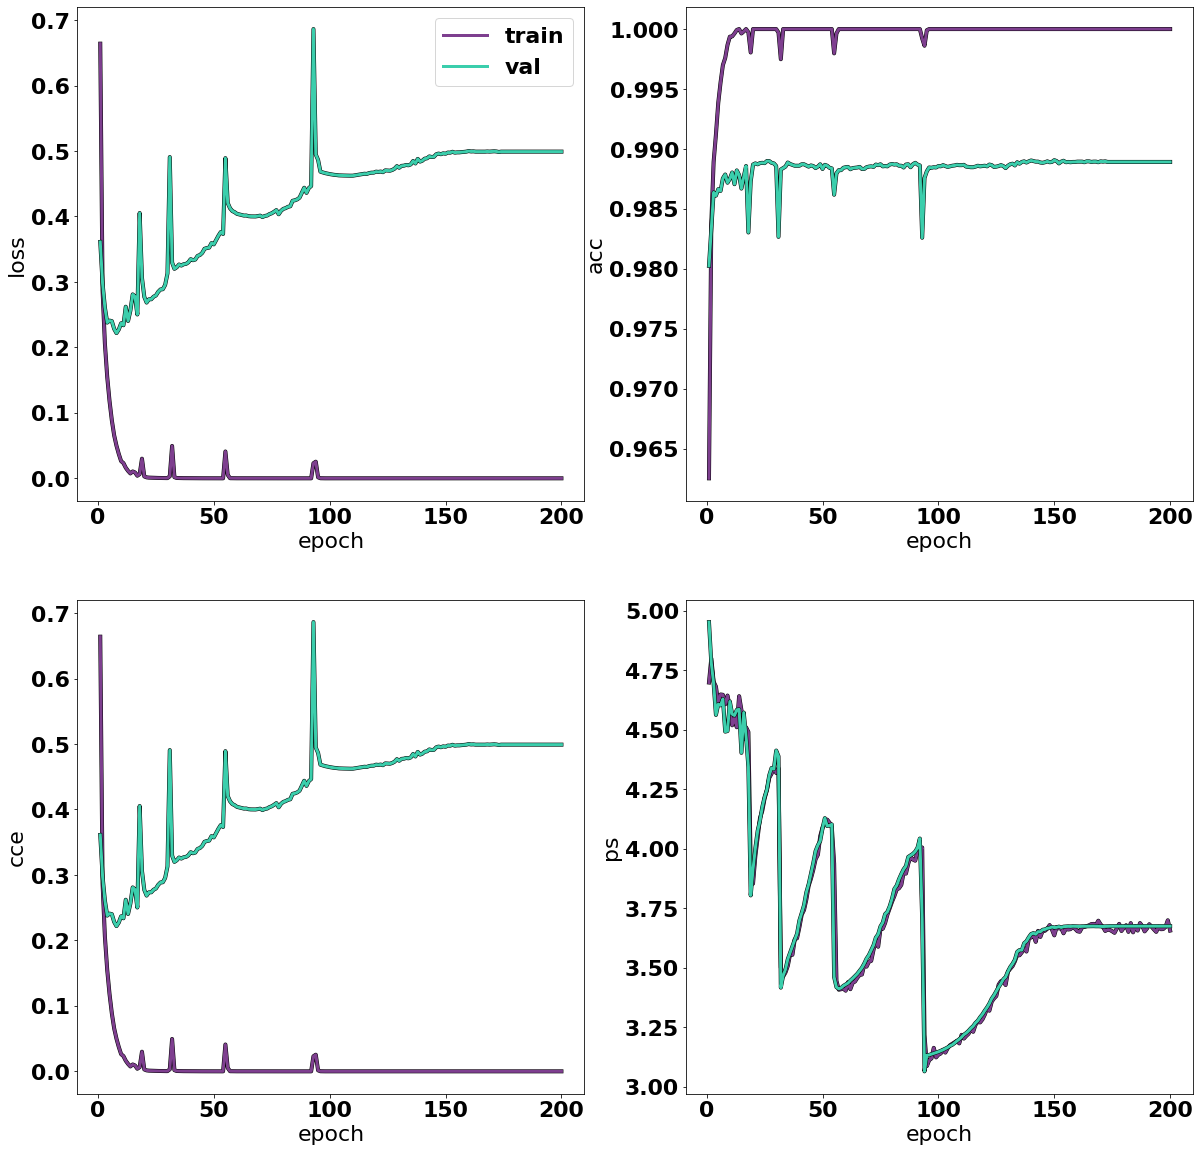

In [15]:
fig = plt.figure(figsize=(20,20))
for j,m in enumerate(['loss', 'acc', 'cce', 'ps']):
    ax = fig.add_subplot(2,2,j+1)
    ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), 'k-', lw=4)
    t, = ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), '-', color='#7E3F8F', lw=3)
    ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), 'k-', lw=4)
    v, = ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), '-', color='#3BCEAC', lw=3)
    ax.set_ylabel(m)
    ax.set_xlabel('epoch')
    if j == 0:
        ax.legend([t, v], ['train', 'val'])


### calculate test set accuracy

In [16]:
inference = tf.keras.Model(inputs=i, outputs=o)
y_pred_test = inference.predict(np.array(x_test_reshape))
print(np.mean(my_acc(y_test, y_pred_test)))

0.989


### calculate activations across the training set

In [17]:
embed = tf.keras.Model(inputs=i, outputs=e)

In [18]:
embed.layers[1].set_weights(model.layers[1].get_weights())
activations_by_class = {}
a = embed.predict(np.array(x_train_reshape))
for j in tqdm(range(len(x_train_reshape[:limit]))):
    try:
        activations_by_class[np.argmax(y_train, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        activations_by_class[np.argmax(y_train, axis=1)[j]] = np.squeeze(a[j])

100%|██████████████████████████████████████████████████████████████████████| 4096/4096 [00:04<00:00, 980.77it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


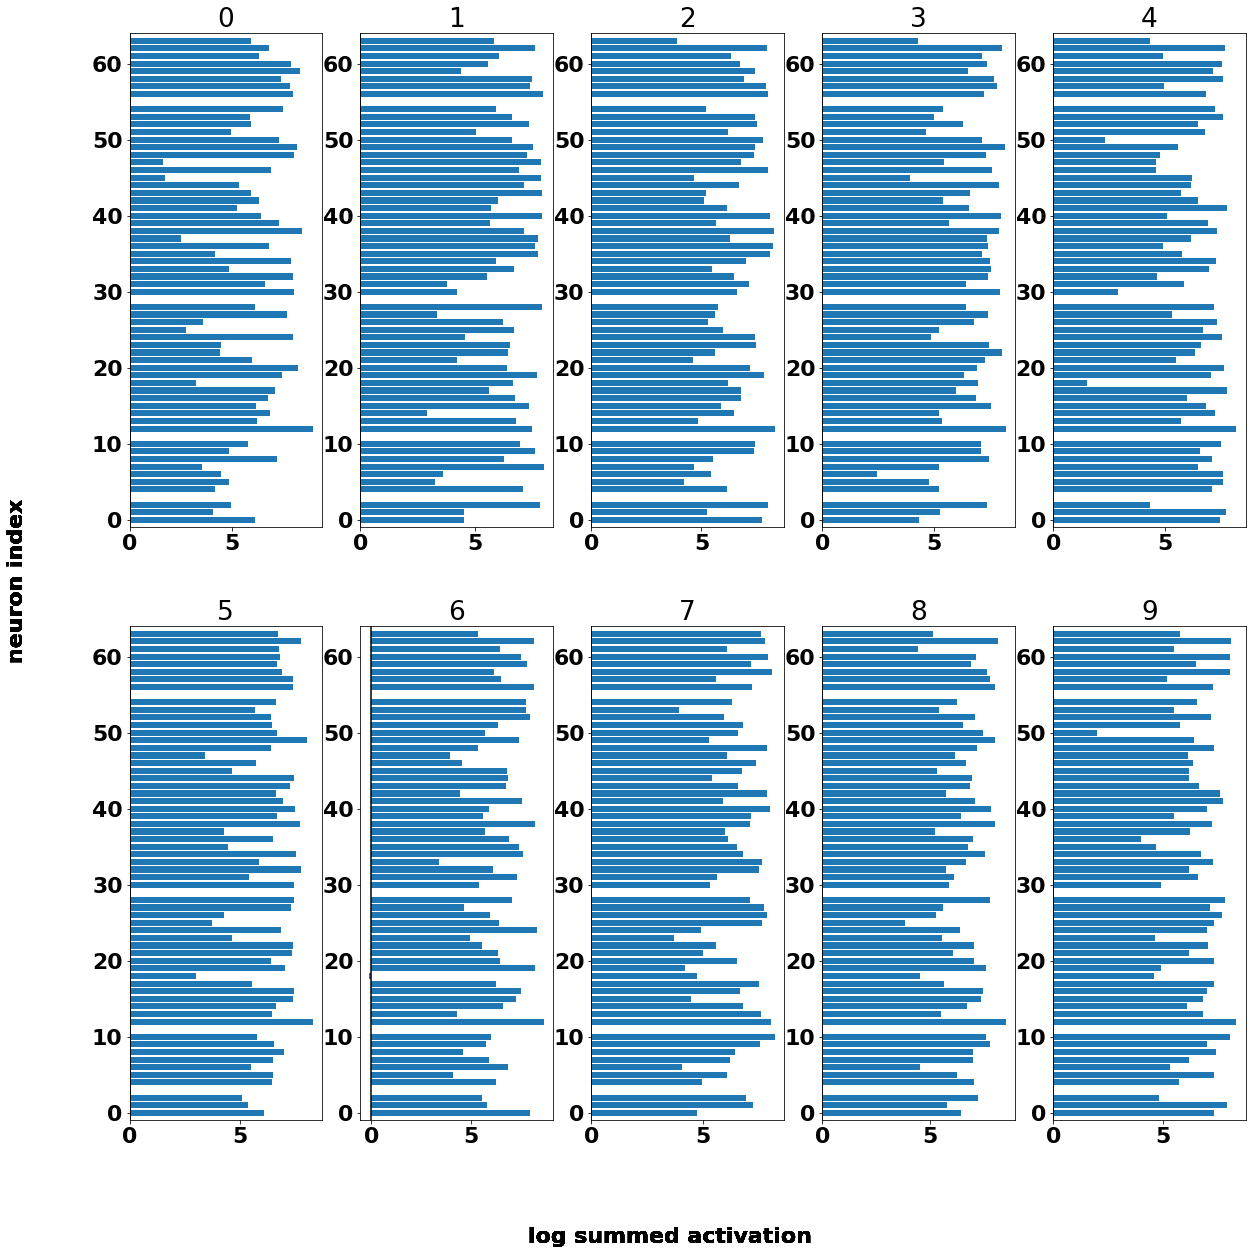

In [19]:
fig = plt.figure(figsize=(20,20))
classes = list(activations_by_class.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(activations_by_class[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(activations_by_class[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(activations_by_class[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(activations_by_class[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### calculate activations across the test set

In [20]:
activations_by_class_test = {}
a = embed.predict(np.array(x_test_reshape))
for j in tqdm(range(len(x_test_reshape))):
    try:
        activations_by_class_test[np.argmax(y_test, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        activations_by_class_test[np.argmax(y_test, axis=1)[j]] = np.squeeze(a[j])

100%|███████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5825.57it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


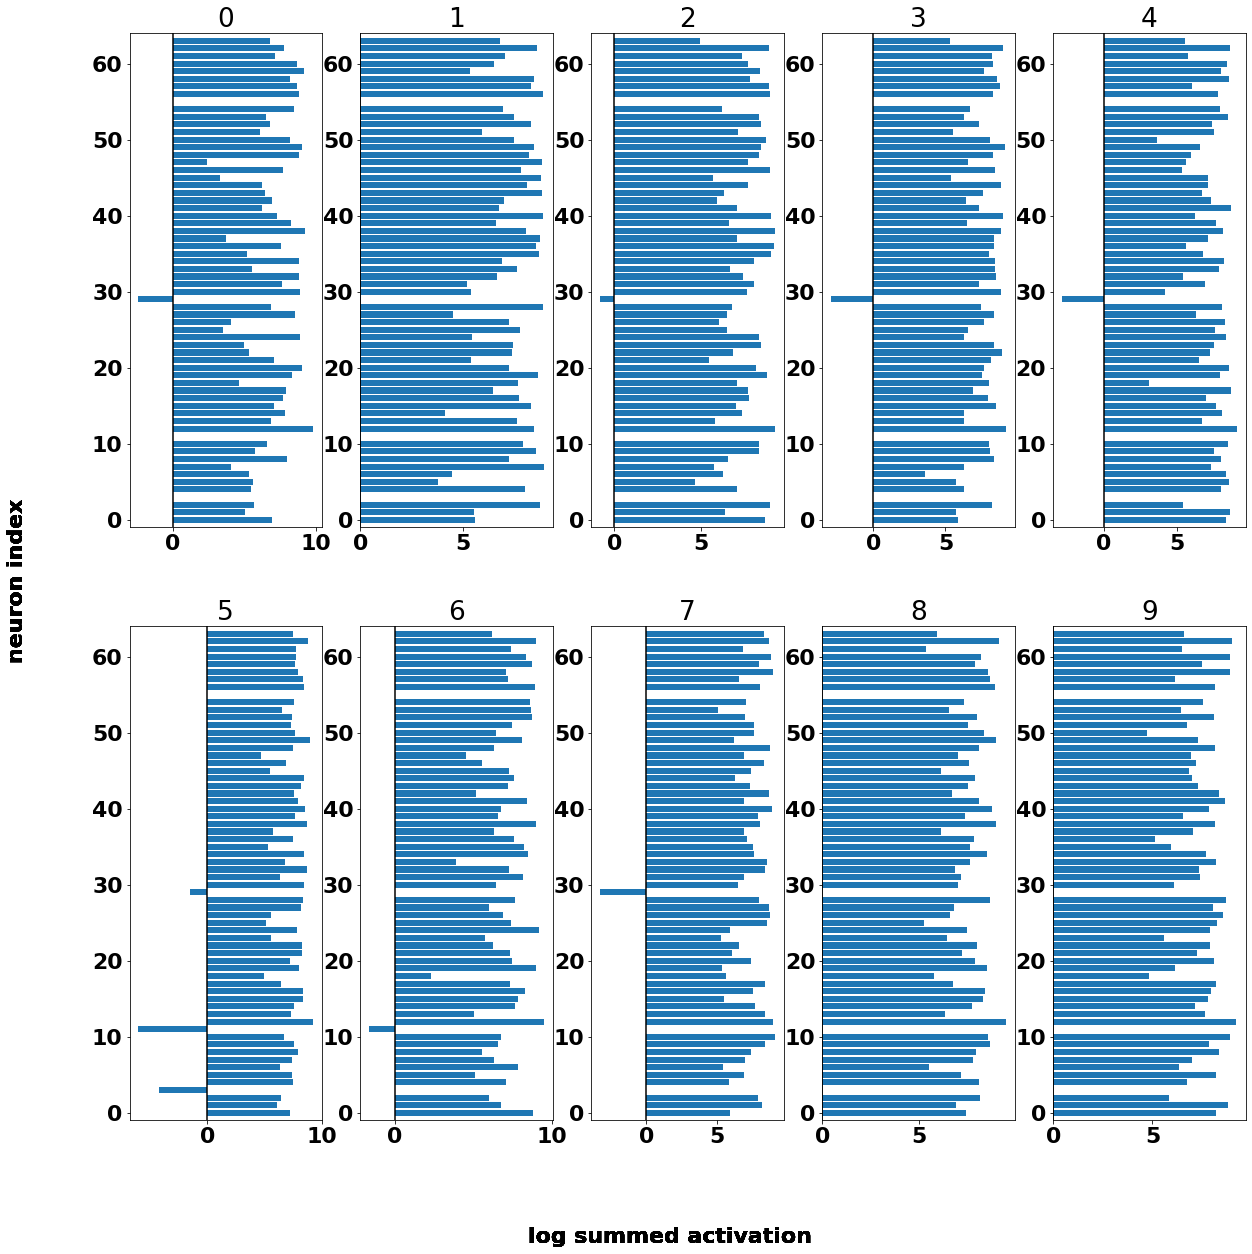

In [21]:
fig = plt.figure(figsize=(20,20))
classes = list(activations_by_class_test.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(activations_by_class_test[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(activations_by_class_test[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(activations_by_class_test[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(activations_by_class_test[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### measure degree of polysemantism across training set activations

In [22]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(activations_by_class[c[0]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[0]])))) + 1e-9)
    b = (np.squeeze(activations_by_class[c[1]]) / (np.max(np.abs(np.squeeze(activations_by_class[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

5.15693015522427


### measure degree of polysemantism across test set activations

In [23]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(activations_by_class_test[c[0]]) / (np.max(np.abs(np.squeeze(activations_by_class_test[c[0]])))) + 1e-9)
    b = (np.squeeze(activations_by_class_test[c[1]]) / (np.max(np.abs(np.squeeze(activations_by_class_test[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

5.111839283837212


### visualise hidden neurons

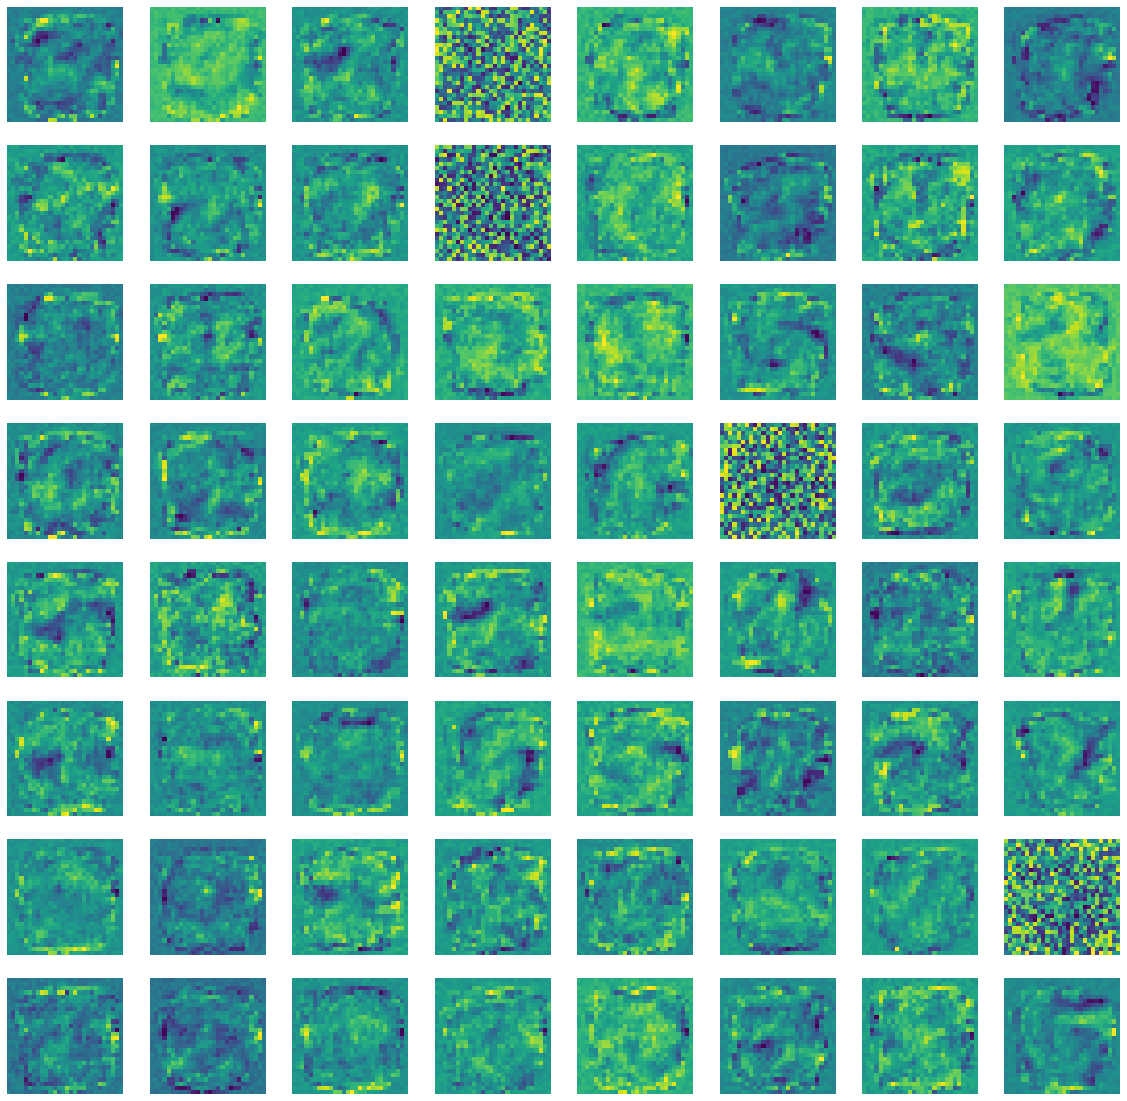

In [24]:
W = embed.layers[1].get_weights()
fig = plt.figure(figsize=(20,20))
dim = int(np.ceil(np.sqrt(n_hidden_neurons)))
for j in range(n_hidden_neurons):
    x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
    ax = fig.add_subplot(dim,dim,j+1)
    ax.imshow(x_j.reshape((28,28)))
    plt.axis('off')
plt.show()